# Workload Generator (_ShareBench-Gen_)

_ShareBench-Gen_ can be used to generate workloads for performance analysis studies of distributed resource-sharing mechanisms and policies.
This notebook provides the workload generation functions. It furthermore provides functions for visualization of generated workloads and collected workload traces.
To help understand the inteded use of the notebook, sample usages of the functions are given.

Note that for workload generation, a set of query statistics (query runtime information) needs to be present as a CSV file. The path of the file can be set with the `FILE_QUERIES` constant.

## Imports and Definitions

In [3]:
FILE_QUERIES = '../data/query-stats/3.csv'
DIR_WORKLOADS = '../docker/workloads/'
DIR_TRACES = '../data/workload-traces'

In [4]:
import pandas as pd
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os

In [5]:
queries = pd.read_csv(FILE_QUERIES)
print(f'Read {len(queries)} queries with average durations from {queries["duration"].min() / 1000:.3f} to {queries["duration"].max() / 1000:.3f} seconds.')

Read 91 queries with average durations from 2.228 to 119.063 seconds.


### Helper Functions

In [6]:
def get_filtered_queries(queries, duration, duration_var, scale_factor=1.0):
    queries_scaled = queries.copy()
    queries_scaled['duration'] = queries_scaled['duration'] * scale_factor
    duration_min = duration - (duration_var)
    duration_max = duration + (duration_var)
    return queries_scaled[(queries_scaled['duration'] >= (duration_min * 1000)) & (queries_scaled['duration'] <= (duration_max * 1000))]

In [7]:
def set_and_get_random_seed(seed=None):
    if seed is None:
        seed = int(time.time() * 1000) % (2**32)
    random.seed(seed)
    return seed

### Generator Functions

In [8]:
def create_bursty(queries, num_apps:int, app_offset, burst_count:int, burst_interval, query_duration, 
                  burst_intensity:int, query_start_offset=0.0, burst_start_var=0.0, query_duration_var=5.0, 
                  burst_intensity_var=0, query_start_delay_var=0.0, initial_delay=0.0, warm_up=0, query_scale_factor=1.0, 
                  rand_seed=None):
    
    """
    Generate a workload with bursty load.

    Parameters
    ----------
    queries : dataframe with columns [query, 'range', 'duration']
        A DataFrame containing all available queries including expected execution durations.
    num_apps : int
        Number of applications.
    app_offset : float
        Per application offset (start delay).
    burst_count : int
        Number of bursts per application.
    burst_interval : float
        Interval between bursts of a single application.
    query_duration : float
        Average query duration.
    burst_intensity : float or list
        Number of queries per burst.
    query_start_offset : float
        Start offset of queries within a single burst.
    burst_start_var : float
        Range of random variation of burst start time in each direction.
    query_duration_var : float
        Range of random variation of query duration in each direction.
    burst_intensity_var : float
        Range of random variation of burst intensity in each direction.
    query_start_delay_var : float 
        Possible random delay of query start time.
    initial_delay : float
        Initial delay before query submissions.
    warm_up : int
        Number of queries submitted at the start of the workload per application for warm-up purposes.
        Ideally used in conjunction with initial delay.
    query_scale_factor : float
        Scale factor of query durations.
    rand_seed : int
        Seed for random operations.
    """
    
    rand_seed = set_and_get_random_seed(rand_seed)
    print(f'Bursty for {num_apps} apps with seed: {rand_seed}')

    workload = pd.DataFrame()
    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    queries_subset['duration'] = queries_subset['duration'] / 1000
    
    for app in range(num_apps):
            
        start_time = initial_delay + app_offset * app

        workload_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            workload_app = warm_up_queries[['query', 'range', 'duration']].copy()
            workload_app['start'] = 0
        else:
            pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        for burst in range(burst_count):
            burst_start_deviation = random.uniform(-1, 1) * burst_start_var
            curr_time = start_time + burst * burst_interval + burst_start_deviation
            if curr_time < initial_delay: curr_time = initial_delay

            burst_intensity_deviation = random.uniform(-1, 1) * burst_intensity_var
            num_queries = burst_intensity + int(round(burst_intensity_deviation))
            rand_seed_burst = (rand_seed + (app + 1) * (burst + 1)) % (2**32)
            random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_burst)
            
            workload_burst = random_queries[['query', 'range', 'duration']].copy().reset_index()
            workload_burst['start'] = (workload_burst.index * query_start_offset) + curr_time
            workload_burst['start'] = workload_burst['start'].apply(lambda x: x + random.uniform(0, query_start_delay_var))

            workload_app = pd.concat([workload_app, workload_burst], ignore_index=True)
            
        workload_app['app'] = app
        workload = pd.concat([workload, workload_app])

    return workload

In [9]:
def create_bursty_alt(queries, num_apps:int, burst_count:int, burst_interval, query_duration, burst_intensity:int,
                   burst_interval_var=0.0, query_duration_var=5.0, burst_intensity_var=0, 
                   query_start_var=0.0, initial_delay=0.0, query_scale_factor=1.0, rand_seed=None):
    
    """
    Alternative (legacy) version of the bursty workload generator function with a different set of parameters.
    
    """
    
    rand_seed = set_and_get_random_seed(rand_seed)
    print(f'Bursty for {num_apps} apps with seed: {rand_seed}')

    workload = pd.DataFrame(columns=['app', 'start', 'query', 'range', 'end'])
    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    
    for app in range(num_apps):
        start_time = initial_delay + burst_interval * app

        workload_app = pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        for burst in range(burst_count):
            # FIXME: this can get negative for the first burst
            burst_start_deviation = random.uniform(-1, 1) * burst_interval_var
            curr_time = start_time + burst * burst_interval * num_apps + burst_start_deviation

            burst_intensity_deviation = random.uniform(-1, 1) * burst_intensity_var
            num_queries = burst_intensity + int(round(burst_intensity_deviation))
            # possibly needs some seed here as well
            rand_seed_burst = (rand_seed + (app + 1) * (burst + 1)) % (2**32)
            random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_burst)
            
            workload_burst = random_queries[['query', 'range', 'duration']]
            workload_burst['start'] = curr_time
            workload_burst['start'] = workload_burst['start'].apply(lambda x: x + random.uniform(0, query_start_var))
            workload_burst['duration'] = workload_burst['duration'] / 1000
            # timeline_burst['end'] = timeline_burst['duration'] + timeline_burst['start']

            workload_app = pd.concat([workload_app, workload_burst], ignore_index=True)
            
        workload_app['app'] = app
        workload = pd.concat([workload, workload_app])

    return workload

In [10]:
def create_constant(queries, num_apps:int, duration, query_duration, intensity, app_offset, query_duration_var=5.0, 
                    query_interval_var=0.0, query_duration_buffer=0.0, initial_delay=0.0, warm_up=0, 
                    query_scale_factor=1.0, rand_seed=None):

    """
    Generate a workload with constant load.

    Parameters
    ----------
    queries : dataframe with columns [query, 'range', 'duration']
        A DataFrame containing all available queries including expected execution durations.
    num_apps : int
        Number of applications.
    duration : float
        Duration of the workload in seconds. 
        Note that the actual workload may be longer due to query submissions at the end of this duration.
    query_duration : float
        Average query duration.
    intensity : float or list
        Average number of concurrent queries per application.
    app_offset : float
        Per application offset (start delay).
    query_duration_var : float
        Range of random variation of query duration in each direction.
    query_interval_var : float
        Range of random variation of query start times.
    query_duration_buffer : float
        Buffer time added to query durations in calculations.
    initial_delay : float
        Initial delay before query submissions.
    warm_up : int
        Number of queries submitted at the start of the workload per application for warm-up purposes.
        Ideally used in conjunction with initial delay.
    query_scale_factor : float
        Scale factor of query durations.
    rand_seed : int
        Seed for random operations.
    """
    
    rand_seed = set_and_get_random_seed(rand_seed)
    print(f'Constant for {num_apps} apps with seed: {rand_seed}')

    workload = pd.DataFrame()

    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    queries_subset['duration'] = queries_subset['duration'] / 1000

    for app in range(num_apps):

        app_intensity = None

        if type(intensity) == list:
            app_intensity = intensity[app]
        else:
            app_intensity = intensity

        workload_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            workload_app = warm_up_queries[['query', 'range', 'duration']].copy()
            workload_app['start'] = 0
        else:
            workload_app = pd.DataFrame()

        curr_time = initial_delay + app_offset * app

        while curr_time < duration + initial_delay:
            query = queries_subset.sample(n=1, random_state=int(rand_seed + app + curr_time))
            query = query[['query', 'range', 'duration']]
            query['start'] = curr_time
            workload_app = pd.concat([workload_app, query])

            curr_time += (query['duration'].mean() + query_duration_buffer) / app_intensity + random.uniform(-1, 1) * query_interval_var
        
        workload_app['app'] = app
        workload = pd.concat([workload, workload_app])

    return workload

In [11]:
def create_constant_alt(queries, num_apps:int, duration, query_duration, query_interval, app_offset, 
                        query_duration_var=5.0, query_interval_var=0.0, initial_delay=0.0, warm_up=0, 
                        query_scale_factor=1.0, rand_seed=None):
    
    """
    Alternative (legacy) version of the constant workload generator function with a different set of parameters.
    
    """
    
    rand_seed = set_and_get_random_seed(rand_seed)
    print(f'Constant for {num_apps} apps with seed: {rand_seed}')

    workload = pd.DataFrame(columns=['app', 'start', 'duration', 'query', 'range'])
    queries_subset = get_filtered_queries(queries, query_duration, query_duration_var, query_scale_factor)
    queries_subset['duration'] = queries_subset['duration'] / 1000

    for app in range(num_apps):

        workload_app = None

        if warm_up > 0:
            warm_up_queries = queries_subset.sample(n=warm_up, replace=True, random_state=rand_seed + (app))
            workload_app = warm_up_queries[['query', 'range', 'duration']].copy()
            workload_app['start'] = 0
        else:
            workload_app = pd.DataFrame(columns=['start', 'duration', 'query', 'range'])

        curr_time = initial_delay + app_offset * app

        while curr_time < duration + initial_delay:
            query = queries_subset.sample(n=1, random_state=int(rand_seed + app + curr_time))
            query = query[['query', 'range', 'duration']]
            query['start'] = curr_time
            workload_app = pd.concat([workload_app, query])

            curr_time += query_interval + random.uniform(-1, 1) * query_interval_var
        
        workload_app['app'] = app
        workload = pd.concat([workload, workload_app])

    return workload

In [12]:
def create_random(queries, num_apps:int, duration, query_duration_min, query_duration_max, intensity, intensity_var=0.0, 
                  initial_delay=0.0, query_scale_factor=1.0, rand_seed=None):
    
    """
    Generate a workload with random load.

    Parameters
    ----------
    queries : dataframe with columns [query, 'range', 'duration']
        A DataFrame containing all available queries including expected execution durations.
    num_apps : int
        Number of applications.
    duration : float
        Duration of the workload in seconds. 
        Note that the actual workload may be longer due to query submissions at the end of this duration.
    query_duration_min : float
        Minimum duration for included queries.
    query_duration_max : float
        Maximum duration for included queries.
    intensity : float
        Average number of queries submitted per minute per application.
    intensity_var : float
        Range of random variation of given intensity in each direction.
    initial_delay : float
        Initial delay before query submissions.
    query_scale_factor : float
        Scale factor of query durations.
    rand_seed : int
        Seed for random operations.
    """

    rand_seed = set_and_get_random_seed(rand_seed)
    print(f'Random for {num_apps} apps with seed: {rand_seed}')

    workload = pd.DataFrame()

    query_duration_avg = (query_duration_max + query_duration_min) / 2
    query_duration_var = query_duration_max - query_duration_avg

    queries_subset = get_filtered_queries(queries, query_duration_avg, query_duration_var, query_scale_factor)
    
    end_time = duration + initial_delay

    for app in range(num_apps):

        num_queries = int(round((intensity + int(round(random.uniform(-1, 1) * intensity_var))) * (duration / 60)))
        rand_seed_app = (rand_seed * (app + 1)) % (2 ** 32)
        random_queries = queries_subset.sample(n=num_queries, replace=True, random_state=rand_seed_app)

        workload_app = random_queries[['query', 'range', 'duration']].copy()
        workload_app['start'] = [random.uniform(initial_delay, end_time) for _ in range(num_queries)]
        workload_app['duration'] = workload_app['duration'] / 1000
        workload_app['app'] = app

        workload = pd.concat([workload, workload_app], ignore_index=True)

    return workload

### Visualization

In [13]:
FIG_CONF = {
    'width': {
        'default': 10,
        'small': 4,
    },
    'height': {
        'default': 3,
        'small': 2,
    },
    'dpi': {
        'default': 100,
        'small': 300,
    },
}

FIG_LABEL_X = 'Time [s]'
FIG_LABEL_Y = 'Active Queries'

BOXPLOT_SPACE = 1
BOXPLOT_WIDTH = .75

MECHANISM_NAMES = ['Static', 'Shared', 'Dynamic']


In [14]:
from helpers.timeline import get_timeline

def get_load_changes(workload):
    if 'start' not in workload.columns:
        raise ValueError("Dataframe must include a 'start' column")

    if 'end' not in workload.columns:
        if 'duration' not in workload.columns:
            raise ValueError("Dataframe must include either a 'end' or 'duration' column")
        workload = workload.copy()
        workload['end'] = workload['start'] + workload['duration']

    start_times = [(time, +1) for time in workload['start']]
    end_times = [(int(math.ceil(time)), -1) for time in workload['end']]

    return sorted(start_times + end_times)

def plot_workload(workload: pd.DataFrame, rolling=None, size='default', xjitter=0, yjitter=0, height=None, width=None, xmin=None, xmax=None):

    fig, ax = plt.subplots(1, 1)

    fig.set_figwidth(FIG_CONF['width'][size])
    fig.set_figheight(FIG_CONF['height'][size])
    fig.set_dpi(FIG_CONF['dpi'][size])

    if height is not None:
        fig.set_figheight(height)
    if width is not None:
        fig.set_figwidth(width)
        
    ax.set_xlabel(FIG_LABEL_X)
    ax.set_ylabel(FIG_LABEL_Y)

    if xmin is not None:
        ax.set_xlim(left=xmin)
    if xmax is not None:
        ax.set_xlim(right=xmax)

    for i, app in enumerate(workload['app'].unique()):

        load_timeline = get_timeline(get_load_changes(workload[workload['app'] == app]))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'])
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))
        ax.plot(df_load['time'] + (xjitter * i), df_load['activeQueries'] + (yjitter * i), label=f'App {app}')
    
    if rolling != None:
        load_timeline = get_timeline(get_load_changes(workload))
        df_load = pd.DataFrame(load_timeline, columns=['time', 'activeQueries'], index=None)
        df_load = df_load.drop_duplicates(subset='time', keep='last')
        df_load = df_load.set_index(pd.to_datetime(df_load['time'], unit='s'))
        df_load = df_load.resample('1s').ffill()
        df_load['rolling_average'] = df_load['activeQueries'].rolling(window=f'{rolling}s').mean()
        ax.plot(df_load['time'], df_load['rolling_average'], label=f'Combined (RW={rolling})', linestyle='dashed')

    ax.legend()
    return

def describe_workload(workload): 
    print(f'Unique query types: {len(workload["query"].unique())}')
    print(f'Unique queries: {workload[["query", "range"]].drop_duplicates().shape[0]}')
    print(f'Shortest: {workload["duration"].min():.3f}s, Median: {workload["duration"].median():.3f}, Longest: {workload["duration"].max():.3f}s')

def plot_workload_durations(workload):
    plt.figure()  # Create a new plot
    plt.boxplot(workload['duration'], showfliers=True)
    plt.xlabel('Duration')
    plt.ylabel('Seconds')
    plt.title('Boxplot of Duration')
    plt.show()

def save_workload(workload: pd.DataFrame, filename, dir=DIR_WORKLOADS):
    workload = workload.copy().sort_values(['start', 'app'])
    workload['start'] = (workload['start'] * 1000).astype(int)
    workload['duration'] = (workload['duration'] * 1000).astype(int)
    path = f'{dir}/{filename}.csv'
    workload[['app', 'start', 'duration', 'query', 'range']].to_csv(path, header=True, index=False)
    print(f'Saved to "{path}"')

### Trace Analysis

In [15]:
def get_trace(id):

    """
    Retrieve trace from workload run with given id.
    """

    dir = f"{DIR_TRACES}/{id}/"
    file_list = os.listdir(dir)
    
    trace = pd.DataFrame()

    for file_name in file_list:
        if file_name.endswith('.csv'):
            trace_app = pd.read_csv(f'{dir}/{file_name}')
            trace = pd.concat([trace, trace_app], ignore_index=True)
    
    trace['duration'] = trace['duration'] / 1000
    trace['start'] = trace['start'] / 1000
    trace = trace.sort_values(['app', 'start'])
    return trace

def analyze_trace(id:str, info="", warmup=150, rolling=None):
    
    """
    Shortcut function to retrieve and plot a trace and print the median query time (for calibration).
    """

    if info:
        print(info)
    trace = get_trace(id)

    plot_workload(trace, rolling)
    trace_no_warmup = trace[trace['start'] >= warmup]

    print(f"Median query time after warm up: {trace_no_warmup['duration'].median()}")

def plot_boxplots(values, names, yscale='linear', xlabel='Mechanism', alternate_colors=False):

    """
    Plot boxplots for a list of lists of values.
    """

    width = len(names) * (BOXPLOT_SPACE)
    fig = plt.figure(figsize = (width, 3))
    ax = fig.add_subplot()  # Create a new plot
    
    ax.set_ylabel('Query Runtime [s]')
    ax.set_yscale(yscale)
    ax.set_xlabel(xlabel)

    flierprops = dict(marker='.', markerfacecolor='#404040', markeredgecolor='#404040', markersize=5, markeredgewidth=1)

    box = ax.boxplot(values, showfliers=True, tick_labels=names, widths=BOXPLOT_WIDTH, flierprops=flierprops)

    dark = cm.Dark2(np.linspace(0, 1, 8))
    colors = [
        dark[3],
        dark[0],
        dark[5],
    ]
    
    for whisker in box['whiskers']:
        whisker.set(color='#404040')

    for median, color in zip(box['medians'], colors):
        if alternate_colors:
            median.set(color=color)
        else:
            median.set(color='#D8662A')

    for outlier in box['fliers']:
        outlier.set(color='#404040')

    fig.show()

def analyze_durations(ids: list, names: list = MECHANISM_NAMES, warmup=150):

    """
    Plot the boxplots of a list of traces. Intended to be used to compare mechanisms.
    """

    durations = []

    for id, name in zip(ids, names):
        trace = get_trace(id)
        trace = trace[trace['start'] >= warmup]
        durations.append(trace['duration'])

    plot_boxplots(durations, names, alternate_colors=True)

## Workload Generation

This section gives some usage examples for each of the generator functions. The individual examples differ both in the choice of function and in the way the function is used to highlight the versatile usage possiblities.

### Bursty (Simple)

Generate, describe, plot, and save a bursty workload for 3 applications.

Bursty for 3 apps with seed: 1
Saved to "../docker/workloads//example_bursty-spaced-long_3.csv"


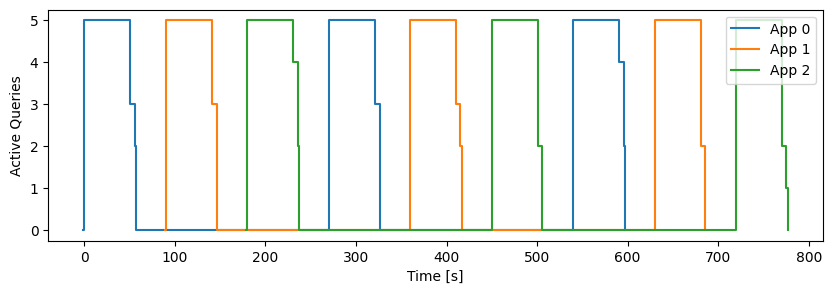

In [16]:
bursty = create_bursty(
    queries,
    num_apps=3,
    app_offset=90,
    burst_count=3,
    burst_interval=90 * 3,
    burst_intensity=5,
    query_duration=55,
    query_duration_var=5,    
    query_scale_factor=5, 
    rand_seed=1
)

plot_workload(bursty, yjitter=0, xjitter=0)
save_workload(bursty, 'example_bursty-spaced-long_3')

### Bursty (Advanced)

Generate, describe, plot, and save 3 different kinds of bursty workload for 2, 3, and 4 applications.

Bursty for 2 apps with seed: 0
Bursty for 2 apps with seed: 0
Bursty for 2 apps with seed: 0
OVERLAPPTING 2
Unique query types: 4
Unique queries: 11
Shortest: 45.812s, Median: 55.262, Longest: 63.405s
SPACED 2
Unique query types: 4
Unique queries: 11
Shortest: 45.812s, Median: 55.262, Longest: 63.405s
SPACED_LONG 2
Unique query types: 4
Unique queries: 11
Shortest: 45.812s, Median: 55.262, Longest: 63.405s
Saved to "../docker/workloads//bursty-overlapping-i10bl60bb5sf300d1800_2.csv"
Saved to "../docker/workloads//bursty-spaced-ii10bl60bb5sf300d1800_2.csv"
Saved to "../docker/workloads//bursty-spaced-long-i10bl90bb35sf300d1800_2.csv"
Bursty for 3 apps with seed: 0
Bursty for 3 apps with seed: 0
Bursty for 3 apps with seed: 0
OVERLAPPTING 3
Unique query types: 4
Unique queries: 11
Shortest: 45.812s, Median: 55.262, Longest: 63.405s
SPACED 3
Unique query types: 4
Unique queries: 11
Shortest: 45.812s, Median: 55.262, Longest: 63.405s
SPACED_LONG 3
Unique query types: 4
Unique queries: 11
S

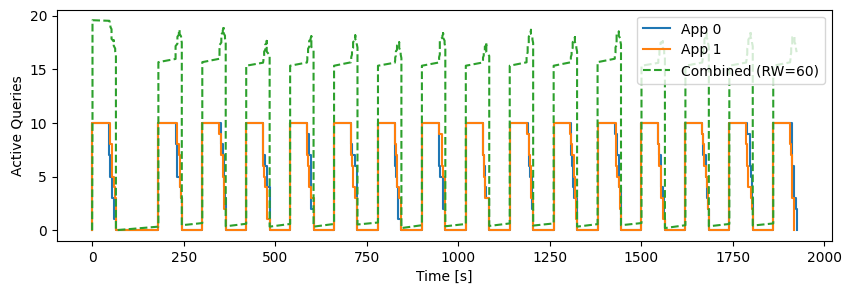

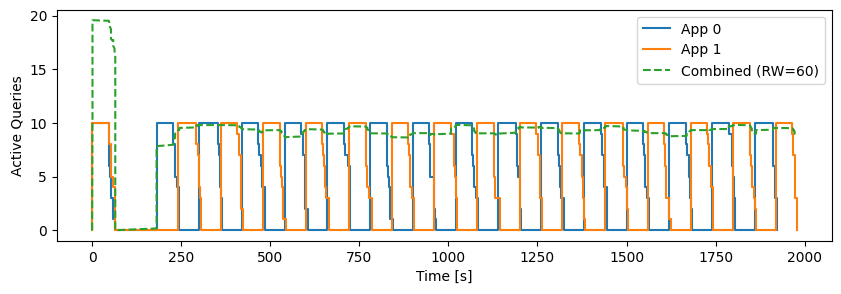

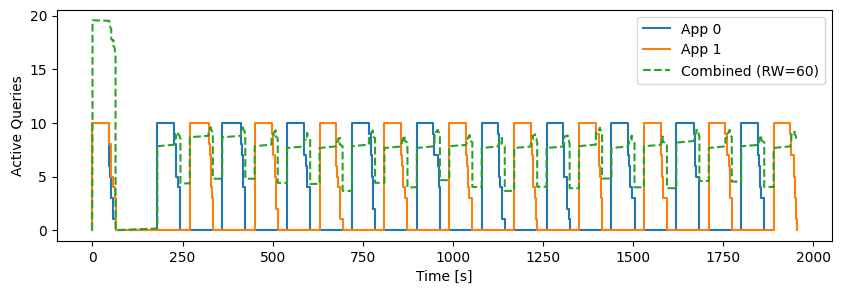

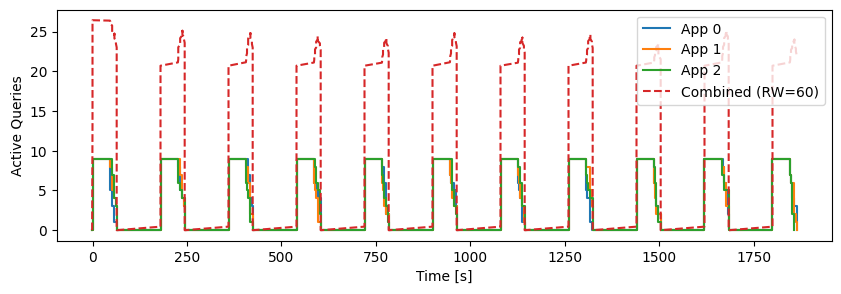

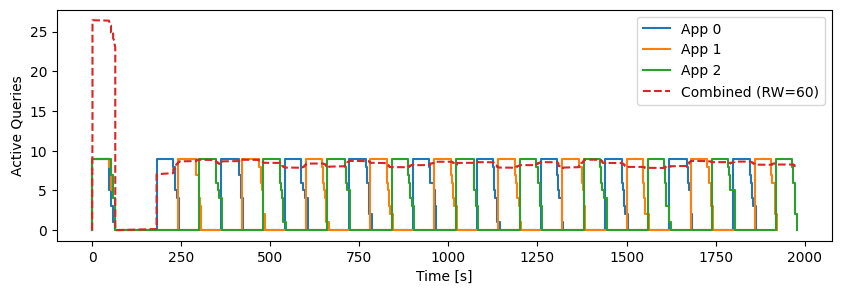

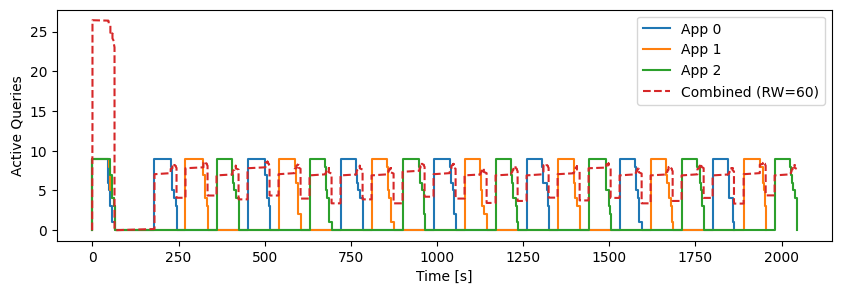

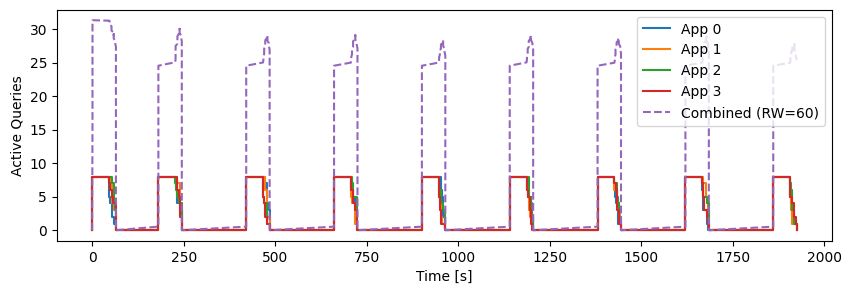

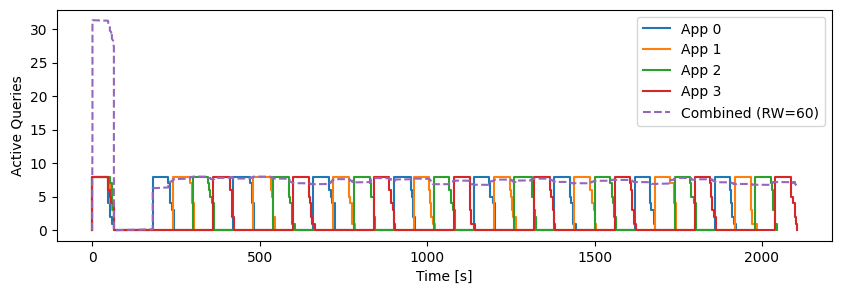

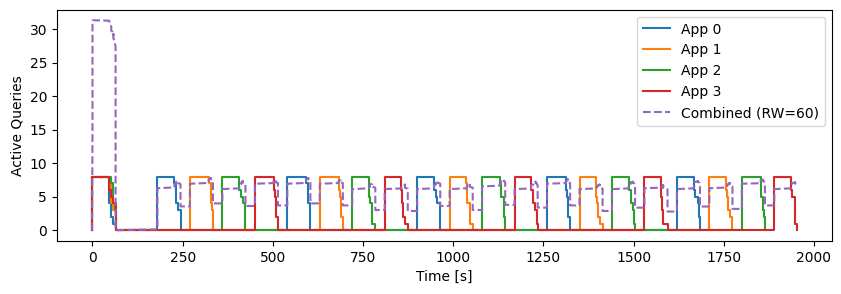

In [17]:
BURST_LEN = 60
BURST_SPACED_LONG_BUFFER = 30
BURST_BUFFER = 5
BURST_INTENSITY = {
    2: 10,
    3: 9,
    4: 8,
}
DURATION_VAR = 10
TOTAL_LEN = 1800
QUERY_START_OFFSET = 0
QUERY_START_VAR = 0
QUERY_SCALE_FACTOR = {
    2: 3,
    3: 3,
    4: 3,
}

def get_id(intensity, burst_len, burst_buffer, scale_factor, total_len, num_apps):
    return f'i{intensity}bl{burst_len}bb{burst_buffer}sf{scale_factor * 100:.0f}d{total_len}_{num_apps}'

for n in range(2, 5):

    bursty_overlapping = create_bursty(
        queries, 
        num_apps=n,
        app_offset=0,
        burst_count=int(math.ceil(TOTAL_LEN / (n * BURST_LEN))),
        burst_interval=n * BURST_LEN,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_delay_var=QUERY_START_VAR,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        rand_seed=0
    )

    bursty_spaced = create_bursty(
        queries, 
        num_apps=n,
        app_offset=BURST_LEN,
        burst_count=int(math.ceil(TOTAL_LEN / (n * BURST_LEN))),
        burst_interval=n * BURST_LEN,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_delay_var=QUERY_START_VAR,
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        rand_seed=0
    )

    burst_len_spaced_long = BURST_LEN + BURST_SPACED_LONG_BUFFER

    bursty_spaced_long = create_bursty(
        queries, 
        num_apps=n,
        app_offset=burst_len_spaced_long,
        burst_count=int(math.ceil(TOTAL_LEN / (n * burst_len_spaced_long))),
        burst_interval=n * burst_len_spaced_long,
        query_duration=BURST_LEN - BURST_BUFFER,
        burst_intensity=BURST_INTENSITY[n],
        query_start_offset=QUERY_START_OFFSET,
        burst_start_var=0,
        query_duration_var=DURATION_VAR,
        burst_intensity_var=0,
        query_start_delay_var=QUERY_START_VAR,
        warm_up=BURST_INTENSITY[n],
        initial_delay=BURST_LEN * 3,
        query_scale_factor=QUERY_SCALE_FACTOR[n],
        rand_seed=0
    )
    
    print(f'OVERLAPPTING {n}')
    describe_workload(bursty_overlapping)
    print(f'SPACED {n}')
    describe_workload(bursty_spaced)
    print(f'SPACED_LONG {n}')
    describe_workload(bursty_spaced_long)

    plot_workload(bursty_overlapping, 60)    
    plot_workload(bursty_spaced, 60)    
    plot_workload(bursty_spaced_long, 60)    
    
    save_workload(
        bursty_overlapping, 
        f'bursty-overlapping-{get_id(BURST_INTENSITY[n], BURST_LEN, BURST_BUFFER, QUERY_SCALE_FACTOR[n], TOTAL_LEN, n)}')
    save_workload(
        bursty_spaced, 
        f'bursty-spaced-i{get_id(BURST_INTENSITY[n], BURST_LEN, BURST_BUFFER, QUERY_SCALE_FACTOR[n], TOTAL_LEN, n)}')
    save_workload(
        bursty_spaced_long, 
        f'bursty-spaced-long-{get_id(BURST_INTENSITY[n], burst_len_spaced_long, BURST_BUFFER+BURST_SPACED_LONG_BUFFER, QUERY_SCALE_FACTOR[n],TOTAL_LEN, n)}')

### Constant

Generate, describe, plot, and save a constant workload for 2 and 3 applications with an overall (cluster) intensity of 12.

Constant for 2 apps with seed: 0
Unique query types: 4
Unique queries: 8
Shortest: 51.079s, Median: 57.178, Longest: 63.405s
Saved to "../docker/workloads//example_constant_2.csv"
Constant for 3 apps with seed: 0
Unique query types: 4
Unique queries: 8
Shortest: 51.079s, Median: 57.532, Longest: 63.405s
Saved to "../docker/workloads//example_constant_3.csv"


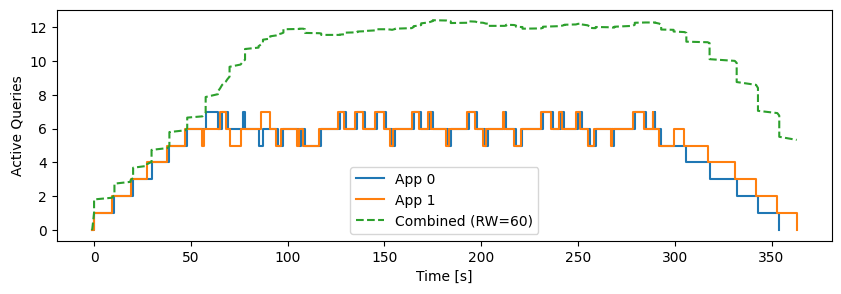

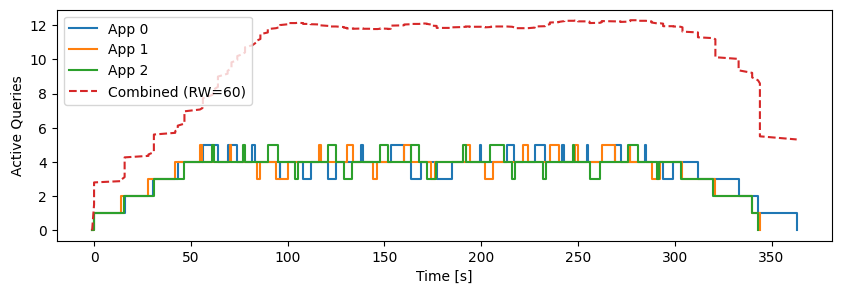

In [18]:
for n in range(2, 4):
    constant = create_constant(
        queries,
        num_apps=n,
        duration=300,
        query_duration=60,
        intensity=12 / n,
        app_offset=0,
        query_duration_var=10,
        query_scale_factor=3,
        rand_seed=0
    )
    describe_workload(constant)
    plot_workload(constant, rolling=60)
    save_workload(constant, f'example_constant_{n}')


### Random

Generate, describe, plot, and save random workloads for a fixed number of applications with 3 intensity levels and accordingly modified scale factors. For each workload, plot the distribution of query durations as a boxplot.

Random for 3 apps with seed: 2532106672
Unique query types: 5
Unique queries: 33
Shortest: 30.270s, Median: 46.211, Longest: 119.154s


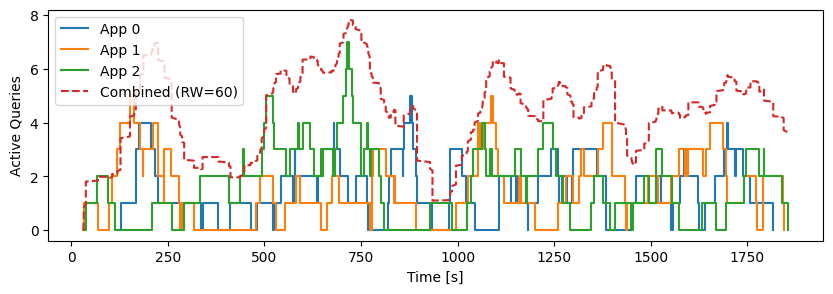

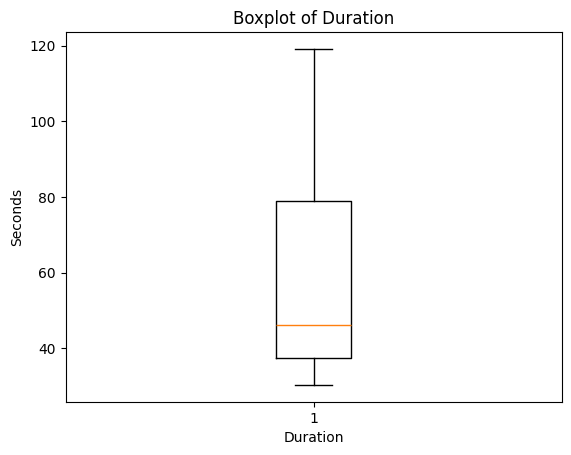

Saved to "../docker/workloads//example_random-i150_3.csv"
Random for 3 apps with seed: 2532106672
Unique query types: 5
Unique queries: 40
Shortest: 31.357s, Median: 50.861, Longest: 105.674s


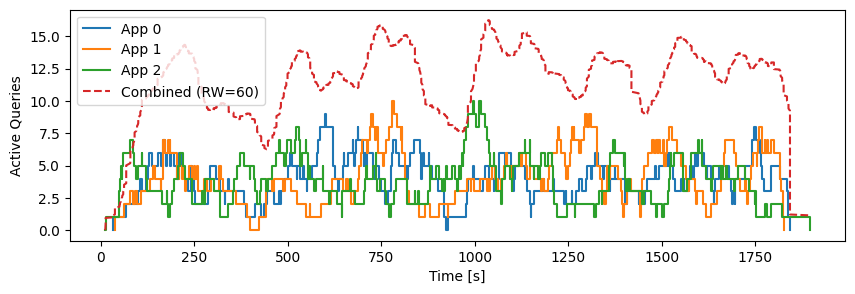

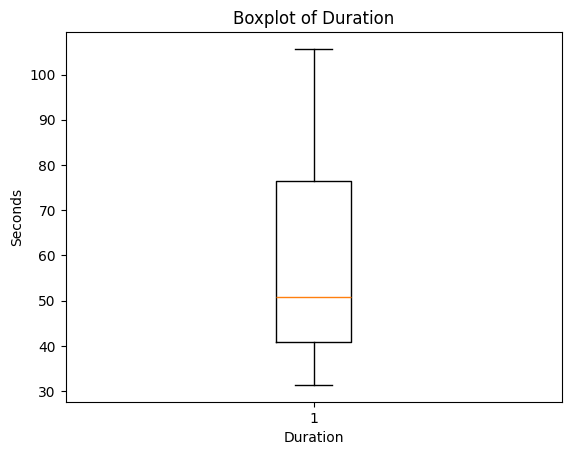

Saved to "../docker/workloads//example_random-i400_3.csv"
Random for 3 apps with seed: 2532106672
Unique query types: 5
Unique queries: 44
Shortest: 31.219s, Median: 55.664, Longest: 115.771s


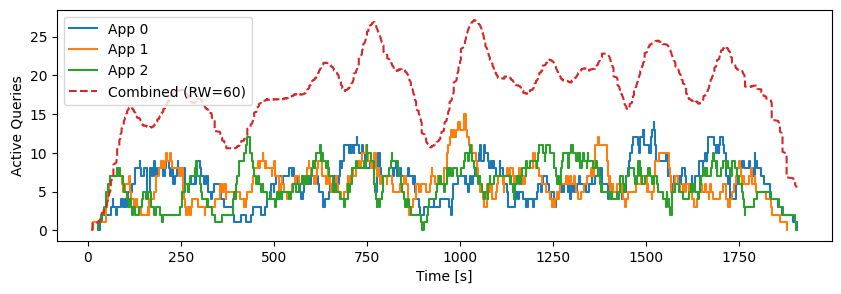

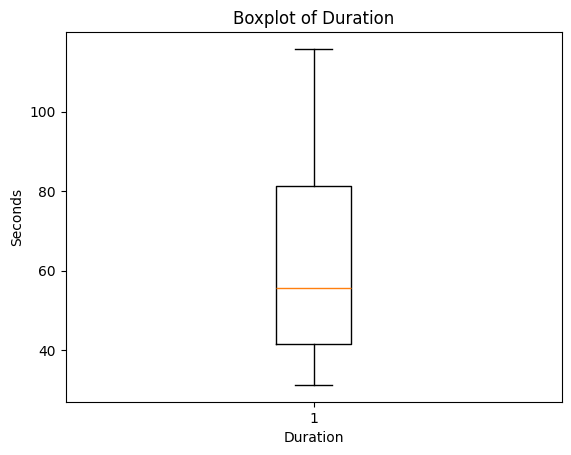

Saved to "../docker/workloads//example_random-i600_3.csv"


In [19]:
for i, sf in [(1.5, 3), (4, 5), (6, 6)]:

    rand = create_random(queries, 3, duration=1800, query_duration_min=30, query_duration_max=120, intensity=i, intensity_var=0, query_scale_factor=sf, rand_seed=2532106672)
    describe_workload(rand)
    plot_workload(rand, rolling=60)
    plot_workload_durations(rand)
    save_workload(rand, f'example_random-i{i * 100:.0f}_3')

### Mixed

Constant for 1 apps with seed: 42
Bursty for 2 apps with seed: 69


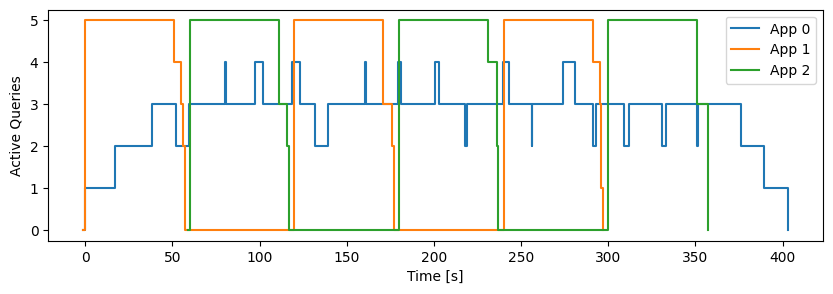

In [21]:
mixed_constant = create_constant(
    queries,
    num_apps=1,
    duration=360,
    query_duration=60,
    intensity=3,
    app_offset=0,
    query_duration_var=10,
    query_scale_factor=3,
    rand_seed=42
)

mixed_bursty = create_bursty(
    queries,
    num_apps=2,
    app_offset=60,
    burst_count=3,
    burst_interval=60 * 2,
    burst_intensity=5,
    query_duration=55,
    query_duration_var=5,    
    query_scale_factor=5, 
    rand_seed=69
)

mixed_bursty['app'] = mixed_bursty['app'] + 1
mixed = pd.concat([mixed_constant, mixed_bursty])

plot_workload(mixed)

## Trace Visualization

This section demonstrates how to use analysis functions to analyze workload traces. Note that the data of workload runs is not part of this repository, and thus these functions will not run.

### Analyze Traces

Workers located on same machine as storage servers:
Median query time after warm up: 15.73
Workers located on a different machine:
Median query time after warm up: 212.294


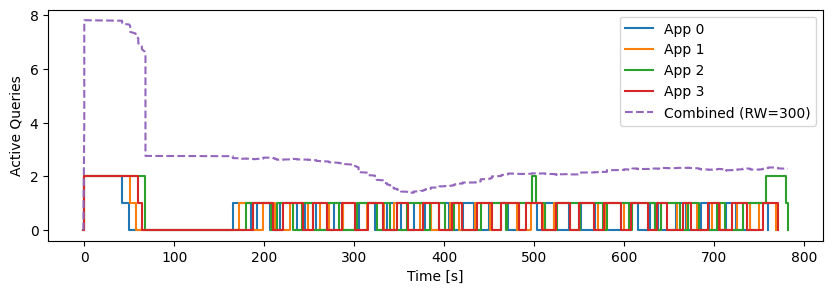

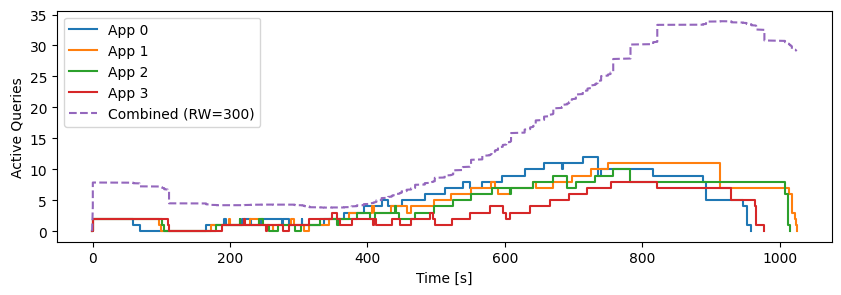

In [71]:
analyze_trace('constant-i2qd60sf600d600_4/1718837726', info='Workers located on same machine as storage servers:', rolling=300)
analyze_trace('constant-i2qd60sf600d600_4/1718835591', info='Workers located on a different machine:', warmup=0, rolling=300)

### Compare Mechanisms

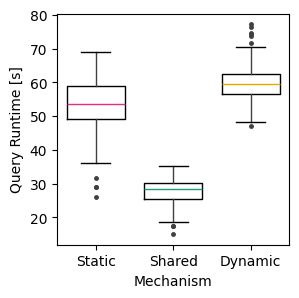

In [76]:
ids = [
    'bursty-spaced-long-i4bl90bb35sf350d1800_3/1718671201',
    'bursty-spaced-long-i4bl90bb35sf350d1800_3/1718684330',
    'bursty-spaced-long-i4bl90bb35sf350d1800_3/1718697640'
]

analyze_durations(ids)